In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [39]:
# For image augmentation in training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image pixel values to [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# For validation and testing data (just rescale)
test_valid_datagen = ImageDataGenerator(rescale=1./255)

# Load data using flow_from_directory
train_dir = '/kaggle/input/potholes-classification-2/train'  # Replace with your actual train directory
valid_dir = '/kaggle/input/potholes-classification-2/valid'  # Replace with your actual validation directory
test_dir = '/kaggle/input/potholes-classification-2/test'  # Replace with your actual test directory

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

valid_generator = test_valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    class_mode='binary'
)

test_generator = test_valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # MobileNetV2 input size
    batch_size=32,
    class_mode='binary'
)

Found 14213 images belonging to 2 classes.
Found 2427 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [40]:
# Load MobileNetV2 pre-trained model without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers (we'll unfreeze later for fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add custom fully connected layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # You can adjust the number of units here
x = Dropout(0.5)(x)  # Dropout to avoid overfitting
x = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Define the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 18,314,817 (69.87 MB)

 Trainable params: 16,056,833 (61.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [41]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Start with 10 epochs and adjust if needed
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 200s 424ms/step - accuracy: 0.8289 - loss: 1.8136 - val_accuracy: 0.9275 - val_loss: 0.1998
Epoch 2/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.8438 - loss: 0.3315

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8438 - loss: 0.3315 - val_accuracy: 0.9292 - val_loss: 0.1931
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 179s 403ms/step - accuracy: 0.8971 - loss: 0.2835 - val_accuracy: 0.9383 - val_loss: 0.1656
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9375 - loss: 0.1266 - val_accuracy: 0.9371 - val_loss: 0.1656
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 180s 405ms/step - accuracy: 0.9099 - loss: 0.2355 - val_accuracy: 0.9371 - val_loss: 0.1772
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9062 - loss: 0.1312 - val_accuracy: 0.9371 - val_loss: 0.1797
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 178s 401ms/step - accuracy: 0.9159 - loss: 0.2158 - val_accuracy: 0.9404 - val_loss: 0.1478
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9688 - loss: 0.1966 - val_accuracy: 0.9404 - val_loss: 0.1490
Epoch 9/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 195s 440ms/step - accuracy: 0.9184 - loss: 0.2050 - val_ac

In [42]:
# Unfreeze the last few layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:  # Fine-tune the last 10 layers (adjust as needed)
    layer.trainable = True

# Recompile the model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model (fine-tuning)
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Fine-tune for additional epochs
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 202s 425ms/step - accuracy: 0.9052 - loss: 0.2403 - val_accuracy: 0.9463 - val_loss: 0.1226
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8750 - loss: 0.3275 - val_accuracy: 0.9454 - val_loss: 0.1242
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 191s 431ms/step - accuracy: 0.9228 - loss: 0.1904 - val_accuracy: 0.9496 - val_loss: 0.1233
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9375 - loss: 0.1312 - val_accuracy: 0.9500 - val_loss: 0.1227
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 192s 431ms/step - accuracy: 0.9284 - loss: 0.1818 - val_accuracy: 0.9546 - val_loss: 0.1183
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9375 - loss: 0.1614 - val_accuracy: 0.9546 - val_loss: 0.1178
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 182s 410ms/step - accuracy: 0.9294 - loss: 0.1755 - val_accuracy: 0.9533 - val_loss: 0.1218
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9688 - loss: 0.22

In [43]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")



37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9376 - loss: 0.1490
Test Loss: 0.14119181036949158
Test Accuracy: 0.9408783912658691


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


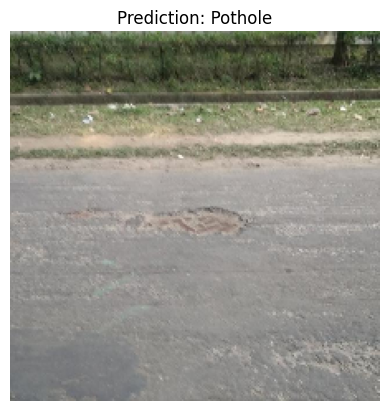

In [46]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load a single image for prediction
img_path = '/kaggle/input/potholes-classification-2/test/Pothole/1074_jpg.rf.e52222c78dc18c6a858b076e0a182815.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))  # InceptionV3 expects 299x299 images

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the batch size (i.e., adding a batch dimension)
img_array = np.expand_dims(img_array, axis=0)

# Rescale the image (as done in the training phase)
img_array = img_array / 255.0

# Make prediction
prediction = model.predict(img_array)

# Show the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title("Prediction: Pothole" if prediction[0] > 0.5 else "Prediction: No Pothole")
plt.show()

In [47]:
# Ground truth for the image (True Label)
true_label = 1  # If the image is a pothole, set it to 1, otherwise 0

# Compare predicted label with the true label
prediction = model.predict(img_array)
predicted_label = 1 if prediction[0] > 0.5 else 0  # If prediction > 0.5, it's Pothole (1), otherwise No Pothole (0)

# Check if the prediction is correct
correct = (predicted_label == true_label)
accuracy = (correct * 100)  # 100% if correct, 0% if incorrect

print(f"Prediction: {'Pothole' if predicted_label == 1 else 'No Pothole'}")
print(f"Accuracy: {accuracy}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediction: Pothole
Accuracy: 100%


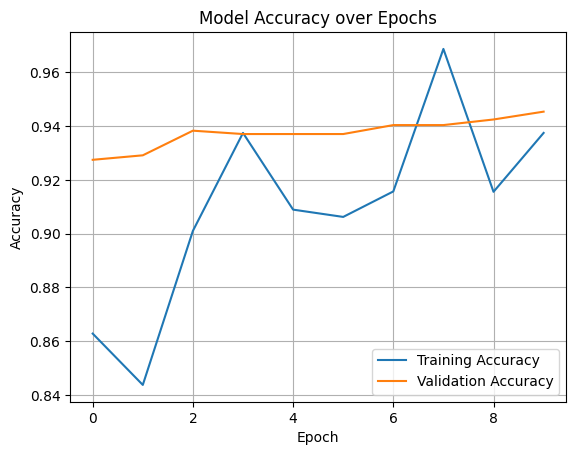

In [48]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [49]:
from tensorflow.keras.callbacks import Callback

class TestAccuracyCallback(Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(
            self.test_generator,
            steps=self.test_generator.samples // self.test_generator.batch_size,
            verbose=0
        )
        self.test_accuracies.append(acc)
        print(f"\nTest accuracy after epoch {epoch+1}: {acc:.4f}")

In [50]:
# Initialize the callback
test_callback = TestAccuracyCallback(test_generator)

# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[test_callback]
)

Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9352 - loss: 0.1606
Test accuracy after epoch 1: 0.9400
444/444 ━━━━━━━━━━━━━━━━━━━━ 186s 419ms/step - accuracy: 0.9352 - loss: 0.1606 - val_accuracy: 0.9521 - val_loss: 0.1197
Epoch 2/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9375 - loss: 0.1437
Test accuracy after epoch 2: 0.9400
444/444 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9375 - loss: 0.1437 - val_accuracy: 0.9521 - val_loss: 0.1201
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9407 - loss: 0.1536
Test accuracy after epoch 3: 0.9426
444/444 ━━━━━━━━━━━━━━━━━━━━ 188s 422ms/step - accuracy: 0.9407 - loss: 0.1536 - val_accuracy: 0.9558 - val_loss: 0.1180
Epoch 4/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.9062 - loss: 0.1806
Test accuracy after epoch 4: 0.9426
444/444 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9062 - loss: 0.1806 - val_accuracy: 0.9550 - val_loss: 0.1199
Epoch 5/10
444/444 ━━━━━

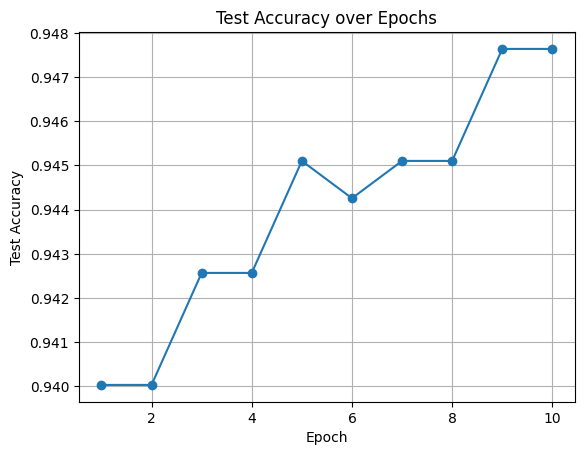

In [52]:
# Plot test accuracy per epoch
plt.plot(range(1, len(test_callback.test_accuracies) + 1), test_callback.test_accuracies, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

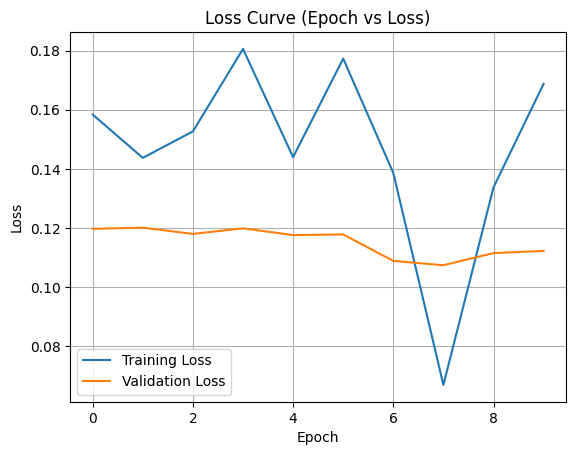

In [54]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss Curve (Epoch vs Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate predictions for the training dataset
train_labels = []
train_predictions = []

# Loop through the training dataset and collect predictions and true labels
for i in range(train_generator.samples // train_generator.batch_size):
    images, labels = next(train_generator)  # Get the next batch
    predictions = model.predict(images)  # Predict labels
    train_labels.extend(labels)  # Add true labels to list
    train_predictions.extend(np.round(predictions))  # Add predicted labels to list

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
train_predictions = np.array(train_predictions)

# Generate confusion matrix
cm_train = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix for Training Data:")
print(cm_train)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━

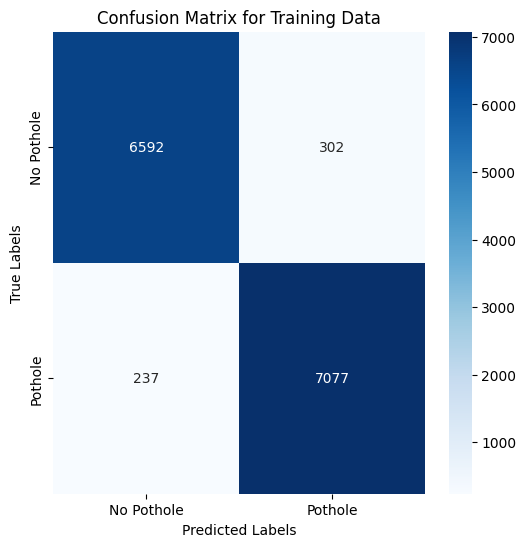

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the training data
cm_train = confusion_matrix(train_labels, train_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pothole', 'Pothole'], yticklabels=['No Pothole', 'Pothole'])
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Accuracy: 0.9621
Precision: 0.9591
Recall: 0.9676
F1 Score: 0.9633


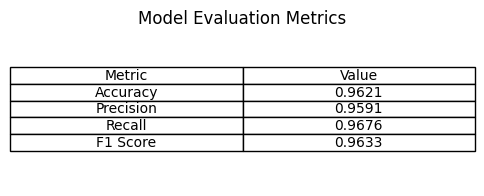

In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming train_labels and train_predictions are already defined (from previous steps)

# Calculate Accuracy
accuracy = accuracy_score(train_labels, train_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision
precision = precision_score(train_labels, train_predictions)
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(train_labels, train_predictions)
print(f"Recall: {recall:.4f}")

# Calculate F1 Score
f1 = f1_score(train_labels, train_predictions)
print(f"F1 Score: {f1:.4f}")
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate the metrics
accuracy = accuracy_score(train_labels, train_predictions)
precision = precision_score(train_labels, train_predictions)
recall = recall_score(train_labels, train_predictions)
f1 = f1_score(train_labels, train_predictions)

# Create the data for the table
metrics = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}']
]

# Plotting the table
fig, ax = plt.subplots(figsize=(6, 2))  # Set size of the figure
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')

# Display the table
plt.title("Model Evaluation Metrics")
plt.show()


In [60]:
# Save the model
model.save('mobileNetV2.h5')  # Save as a .h5 file

print("Model saved successfully!")


Model saved successfully!
